In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('project-course-gkomliki')
jovian.set_colab_id('1CxJCQ6eMGn43Kg3YkSLiulc6-eCrrw7N')

In [ ]:
# Project name used for jovian.commit
project_name = 'Project_course_gkomliki'

In [ ]:
jovian.commit(project_name,environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/gkomliki/project-course-gkomliki


'https://jovian.ai/gkomliki/project-course-gkomliki'

In this project we will work the KMNIST dataset which is already incorporated in the `torchvision.datasets` library. This specific dataset Kuzushiji-MNIST is a drop-in replacement for the MNIST dataset (28x28 grayscale, 70,000 images), provided in the original MNIST format as well as a NumPy format. Since MNIST restricts us to 10 classes, we chose one character to represent each of the 10 rows of Hiragana when creating Kuzushiji-MNIST.The first step will be to import some important libraries that they will proven useful in the training of our model.

In [ ]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torchvision.datasets import KMNIST
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms as tt
from torch.utils.data import random_split

## 1.**Downloading the dataset**
The first thing we'll do is to download our datset straight from the `torchviviondatasets`.

In [ ]:
dataset= KMNIST(root='data/', download=True)

In [ ]:
#Checking the length of the dataset
len(dataset)

60000

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FBD6C56E6D0>, 8)

The image is an object of the class `PIL.Image.Image`, which is a part of the Python imaging library Pillow. We can view the image using matplotlib or plotly, the plotting and graphing libraries
 for data science in Python.

In [ ]:
#Checking of the test_dataset lengh
test_dataset = KMNIST(root='data/',train=False)
len(test_dataset)



10000

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 8


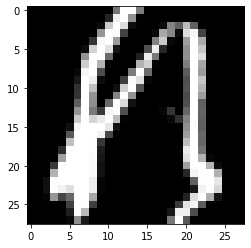

In [ ]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

We transform the PIL image into Tensor using  `ToTensor()` argument.

In [ ]:
dataset = KMNIST(root='data/',train=True,transform=ToTensor())

In [ ]:
img,label=dataset[0]
print(img.shape,label)


torch.Size([1, 28, 28]) 8


Let's visualize our tensot this time

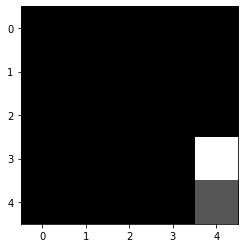

In [ ]:
plt.imshow(img[0,15:20,15:20],cmap='gray');

## 2. **Splitting our dataset** 
The next step is to split the dataset into training and validation set in order ot train our model and later to validate its predictions (chekc if the predictions are closely approximate the labels). We define a validation set size=10000 and the rest of the data we'll be used for training.



In [ ]:
valid_size = 10000
train_size= len(dataset)- valid_size
# Splitting of the data using the random_split
train_ds, valid_ds = random_split(dataset, [train_size,valid_size])
len(train_ds),len(valid_ds)


(50000, 10000)

In [ ]:
jovian.commit(project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/gkomliki/project-course-gkomliki


'https://jovian.ai/gkomliki/project-course-gkomliki'

## 3. **Data Loading usinf DataLoaders**
Next step will be to load our data in batces to the dataloaders. We define a batch size of 128 and if necessary we will adapt it later.

In [ ]:
batch_size = 128

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# Loading the data using DataLoader()
train_dl=DataLoader (train_ds, batch_size, shuffle=True,num_workers=2,pin_memory=True)
valid_dl = DataLoader(valid_ds, 2*batch_size, num_workers=2, pin_memory=True)


In [ ]:
jovian.commit(project_name,Environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/gkomliki/project-course-gkomliki


'https://jovian.ai/gkomliki/project-course-gkomliki'

## 4. **Data Transfer form CPU to GPU**

The next step is to create a pipeline that will move data form a CPU to the colab GPU. GPU can optimize the performance of the matrix operations and significantly increase the speed of the training of our model. In the selected dataset, the use of a GPU will not be necessary. However we construct the pipeline to indicate how this process could have taken place of necessary

First we chack if the required NVIDIA cuba drivers are available:

In [ ]:
torch.cuda.is_available()

True

Now, we procced by defining a helper function to ensure that our code uses the GPU if it is available and defaults to using the CPU if it isn't.

In [ ]:
def get_default_device():
  # Use GPU if available else use CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device= get_default_device()
device

device(type='cuda')

Next, we define our pipeline for the data:

In [ ]:
def to_device(data,device):
  # Move Tensors data to the chosen device
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

In [ ]:
for img,labels in train_dl:
  print(img.shape)
  images= to_device(img,device)
  print(images.device)
  break


torch.Size([128, 1, 28, 28])
cuda:0


The last step is to define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. We don't need to extend an existing class to create a PyTorch data loader. What we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

In [ ]:
class DeviceDataLoader():
  # Wrap a data loader to move data to a device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    # Yield a batch of data after moving it to the device
    for x in self.dl:
      yield to_device(x,self.device)

  def __len__(self):
    # Number of batches
    return len(self.dl)


We can now wrap our data loaders using `DeviceDataLoader`.

In [ ]:
train_dl = DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl,device)

Tensors moved to the GPU have a `device` property which includes the word cuda or cpu. Let's verify this by looking at a batch of data from train_dl.

In [ ]:
for xb, yb in train_dl:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([4, 9, 0, 6, 3, 2, 6, 7, 4, 7, 6, 3, 4, 0, 4, 7, 3, 5, 6, 9, 0, 5, 7, 8,
        6, 8, 5, 5, 1, 8, 1, 3, 1, 8, 0, 4, 7, 1, 1, 6, 4, 1, 4, 6, 7, 5, 9, 8,
        2, 3, 1, 3, 3, 7, 4, 6, 6, 5, 8, 4, 9, 8, 6, 8, 1, 9, 4, 3, 9, 9, 9, 1,
        7, 2, 4, 2, 4, 2, 1, 9, 0, 3, 5, 3, 8, 5, 3, 9, 9, 4, 6, 0, 5, 1, 1, 5,
        6, 2, 4, 0, 4, 1, 6, 3, 5, 1, 2, 6, 3, 5, 8, 3, 2, 3, 1, 5, 9, 8, 8, 3,
        5, 5, 1, 6, 7, 9, 9, 3], device='cuda:0')


In [ ]:
jovian.commit(project_name,Environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/gkomliki/project-course-gkomliki


'https://jovian.ai/gkomliki/project-course-gkomliki'

## 5. ***Defining and Training the model***:

For the purpose of the project we will start by defining a ***Convolutional Neural Network (CNN)***, train it, and based on its calculated accuracy we will decide if a further action is required e.g. adding a residual block architecture for instance. Let's start by defining the model:  


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
input_size=28*28
num_classes=10

We define a class which will help us for train and validation of our model:


We'll use `nn.Sequential` to chain the  CNN layers and activations functions into a single network architecture defined below arbitrally.



In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
class KMnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #output 64x14x14
            nn.Flatten(), 
            nn.Linear(64*14*14, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10))
            #self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        #xb = xb.reshape(-1, 784)
        #out = self.linear(xb)
        return self.network(xb)
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = KMnistModel()    
   


    

In [ ]:
to_device(model, device);

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 1, 28, 28])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.1165, -0.0021,  0.0029, -0.0999,  0.0852,  0.0223, -0.1458,  0.0100,
        -0.0669, -0.0469], device='cuda:0', grad_fn=<SelectBackward0>)


Let's transfer batches of data to the GPU , and use to_device to move our model to the GPU (if available).

In [ ]:
to_device(model, device);

In [ ]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/gkomliki/project-course-gkomliki


'https://jovian.ai/gkomliki/project-course-gkomliki'

It is time to train our model. We define 2 functions: `fit` and `evaluate` 
and we use gradient descent ti evaluate the model performance on the validation set.

In [ ]:
@torch.no_grad()
def evaluate(model,valid_dl):
  model.eval()
  out = [model.validation_step(batch) for batch in valid_dl]
  return model.validation_epoch_end(out)
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    train_losses = []
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

Before we begin training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [ ]:
model = to_device(KMnistModel(), device)

In [ ]:
evaluate(model,valid_dl)

{'val_loss': 2.3046212196350098, 'val_acc': 0.11513672024011612}

In [ ]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.05

In [ ]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})


[jovian] Hyperparams logged.


In [ ]:
history = fit(num_epochs, lr, model, train_dl, valid_dl)

Epoch [0], val_loss: 0.4062, val_acc: 0.8675
Epoch [1], val_loss: 0.2790, val_acc: 0.9098
Epoch [2], val_loss: 0.2191, val_acc: 0.9325
Epoch [3], val_loss: 0.1947, val_acc: 0.9394
Epoch [4], val_loss: 0.2004, val_acc: 0.9389


In [ ]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.01

In [ ]:
history = fit(num_epochs, lr, model, train_dl, valid_dl)

Epoch [0], val_loss: 0.1413, val_acc: 0.9584
Epoch [1], val_loss: 0.1391, val_acc: 0.9585
Epoch [2], val_loss: 0.1367, val_acc: 0.9600
Epoch [3], val_loss: 0.1371, val_acc: 0.9615
Epoch [4], val_loss: 0.1340, val_acc: 0.9627


In [ ]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


In [ ]:
history = fit(num_epochs, lr, model, train_dl, valid_dl)

Epoch [0], val_loss: 0.1317, val_acc: 0.9624
Epoch [1], val_loss: 0.1320, val_acc: 0.9620
Epoch [2], val_loss: 0.1322, val_acc: 0.9627
Epoch [3], val_loss: 0.1322, val_acc: 0.9625
Epoch [4], val_loss: 0.1322, val_acc: 0.9628


In [ ]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.0001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, valid_dl)

The model performs quite well with almost 96% accuracy. Perhaps with the introduction of a residual block or a `resnet` architecture we could possibly achive accuracies close to 99%! 

We can also plot the valdation set accuracies to study how the model improves over time. We define a plot_accuracies function to do so.


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

Our model reaches an accuracy of around 96%, and by looking at the graph, it seems unlikely that the model will achieve an accuracy higher than that even after training for a long time. 
We can also plot the training and validation losses to study the trend.

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

Initialy, both the training and validation losses seem to decrease over time. However, if you train the model for long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point.

## 6. **Test With individual images**

In [ ]:
# Define test dataset
test_dataset = KMNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Let's try to predict some images

In [ ]:
img, label = test_dataset[0]

print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[7233]

print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set, and record using `jovian`. We expect these values to be similar to those for the validation set. If not, we might need a better validation set that has similar data and distribution as the test set (which often comes from real world data).

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

In [ ]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_acc'])

In [ ]:
jovian.commit(project_name)

## Conclusion

The FashionMNIST dataset is a well-known dataset used for image classifications problems. We have a defined an arbitrary deep learning architecture which gave adequately good resultsand can be used as a reference to fusther improve the model in the future with the use of Residual blocks architectures perhaps or by addinf more Convolutional layers to capture more details in the images and produce better results. The model was trained at GPU cuba drivers in a computatioanly efficient way. For the future I will focus on trying different architectures in more complicated datasets and expand my skills.

## References:
1) https://github.com/rois-codh/kmnist: The KMNIST dataset

2) https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53: A smooth introduction to Convolutional Neural networks.

3) https://towardsdatascience.com/how-to-traine-tensorflow-models-79426dabd304 : How to use a GPU to train a machine learning model.

4) https://pytorch.org/ : A complete guide to Pytorch.
